# DSC 180A Paper Replication
### Microbial Diversity in Clinical Microbiome Studies: Sample Size and Statistical Power Considerations
## Setup

In [1]:
import sys
print(sys.executable)
import rpy2.robjects as ro
from rpy2.robjects.packages import isinstalled

import os

os.environ["PATH"] = "/home/k5zhao/.conda/envs/qiime2-amplicon-2025.7/bin:" + os.environ["PATH"]

# Force R (used by rpy2) to look in the env's R library
ro.r('.libPaths("/home/k5zhao/.conda/envs/qiime2-amplicon-2025.7/lib/R/library")')

print("R libPaths now:")
print(ro.r(".libPaths()"))
print("phyloseq installed?", isinstalled("phyloseq"))

/home/k5zhao/.conda/envs/qiime2-amplicon-2025.7/bin/python
R libPaths now:
[1] "/home/k5zhao/.conda/envs/qiime2-amplicon-2025.7/lib/R/library"
[2] "/opt/conda/lib/R/library"                                     

phyloseq installed? True


## Imports

QIIME2 is the

In [2]:
import pandas as pd
import qiime2 as q2
import seaborn as sns
import matplotlib.pyplot as plt
import re

from statsmodels.stats.power import tt_ind_solve_power
from statistics import mean, stdev
from skbio import DistanceMatrix
from qiime2.plugins import fragment_insertion, diversity
from qiime2 import Metadata, Artifact
from qiime2.plugins.feature_table.methods import rarefy
from qiime2.plugins.phylogeny.methods import midpoint_root
from skbio import TreeNode
from skbio.diversity.alpha import faith_pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

/home/k5zhao/.conda/envs/qiime2-amplicon-2025.7/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Data Preprocessing

In [3]:
ft = Artifact.load('78873_feature-table.qza')
ft.view(pd.DataFrame)

,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACC,ACGTAGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTTAAGTCAGGAGTGAAAGGCTACGGCTCAACC,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACC,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGACGGGCAAGTCTGAAGTGAAAGGCAGGGGCTCAACC,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAAGAGCAAGTCTGATGTGAAAGGCTGGGGCTTAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACC,ACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACG,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTTAACC,ACGTATGTCACGAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCAGGGCTCAACT,...,ACGTAGGGAGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGTCAGCAAGTCCGTTGTTAAATCTACCGGCTCAACC,ATGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGAGTAGGCGGGATTACAAGTCTGATGTGAAATACCGAGGCTTAACT,ACATAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGCGTGCAGCCGGGCCGGCAAGTCAGATGTGAAATCTGGAGGCTTAACC,ATGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGTGCGTAGGCGGCGGATTAAGTCCGGAGTAAAATTGTGGGGCTCAACC,ACATAGGGGGCGAGCGTTATCCGGAATTACTGGGTGTAAAGGGTGCGTAGGCGGCATCGTAAGTCTGTTGTGAAAGGCGATGGCTTAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGTAGATCAAGTCGCATGTGAAATACCCGGGCTCAACC,ATGTAGGGGGCGAGCGTTATCCGGAATCATTGGGCGTAAAGAGCGCGTAGGCGGCCCCTCAAGCGGGATCTCTAATCCGAGGGCTCAACC,AGGTAGGGGGCAAGCGTTATCCGGAATTACTGGGTGTAAAGGGTGAGTAGGCGGCACGGCAAGTAAGATGTGAAAGCCCACGGCTTAACT,ACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTATGCCGTCTTCTGCTTGAAAAAAGAAAATTTGCGGCTCAACC,ACCTAGGTCCCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACC
1629.SubjectIBD026,46430.0,18924.0,6645.0,5276.0,4450.0,2324.0,1322.0,1279.0,1043.0,915.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD414,0.0,41.0,0.0,82.0,0.0,0.0,0.0,1429.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD244,1551.0,1089.0,0.0,3248.0,0.0,4385.0,0.0,15048.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD198,0.0,8573.0,0.0,21.0,0.0,0.0,0.0,271.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629.SubjectIBD222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD195,0.0,779.0,78.0,0.0,0.0,0.0,0.0,2234.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD472,0.0,267.0,653.0,0.0,0.0,0.0,0.0,3999.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD040,0.0,18.0,0.0,0.0,0.0,0.0,0.0,1485.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,1.0,1.0,0.0,0.0


In [4]:
rarefied = rarefy(table=ft, sampling_depth=10000).rarefied_table
# rarefied.save('rarefied_table.qza')
rarefied_df = rarefied.view(pd.DataFrame)
rarefied_df.head()

,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACC,ACGTAGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTTAAGTCAGGAGTGAAAGGCTACGGCTCAACC,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACC,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGACGGGCAAGTCTGAAGTGAAAGGCAGGGGCTCAACC,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAAGAGCAAGTCTGATGTGAAAGGCTGGGGCTTAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACC,ACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACG,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTTAACC,ACGTATGTCACGAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCAGGGCTCAACT,...,ACGGAGGATCCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACC,ACGTAGGGGGCTAGCGTTATCCGGAATTACTGGGCGTAAAGGGTGCGTAGGTGGTTTTTTAAGTCAGAAGTGAAAGGCTACGGCTCAACC,ACGTAGGGGGCGAGCGTTGTCCGGAATGACTGGGCGTAAAGGGTGTGTAGGTGGTTTGATAAGTTAGAGGTGAAATCCCGGGGCTTAACT,ACGTAGGTGGCGGGCGTTATCCGGAATTATTGGGCGTAAAGGGTGCGCAGGCGGTTTTTAAGTTTAAGGTGAAAGCGTGGGGCTTAACCC,ACGTAGGGGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGTGCGTAGGTGGTTTTTTAAGCGCGGGGTGAAAGGCAAAGGCTCAACC,ACGGAGGATACGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGTGGTATTGTAAGTCAGGGGTGAAAAGCTATAGCTCAACT,ACGTAGGGGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCCGTGAGGTAAGCGTGTTGTGAAATGTAGGCGCCCAACG,ACATAGGGGGCGAGCGTTATCCGGAATTACTGGGTGTAAAGGGTGCGTAGGCGGCATCGTAAGTCTGTTGTGAAAGGCGATGGCTTAACC,ATGTAGGGGGCGAGCGTTATCCGGAATCATTGGGCGTAAAGAGCGCGTAGGCGGCCCCTCAAGCGGGATCTCTAATCCGAGGGCTCAACC,ACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTATGCCGTCTTCTGCTTGAAAAAAGAAAATTTGCGGCTCAACC
1629.SubjectIBD026,5046.0,2065.0,760.0,581.0,502.0,253.0,152.0,141.0,102.0,113.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD414,0.0,4.0,0.0,2.0,0.0,0.0,0.0,44.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD244,121.0,70.0,0.0,259.0,0.0,341.0,0.0,1220.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD198,0.0,497.0,0.0,2.0,0.0,0.0,0.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,523.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
insertion_tree = q2.Artifact.load('insertion-tree.qza')

faith_res = diversity.actions.alpha_phylogenetic(
    table=rarefied,
    phylogeny=insertion_tree,
    metric='faith_pd'
)

faith_pd = faith_res.alpha_diversity.view(pd.Series)
faith_pd

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /tmp/qiime2/k5zhao/processes/447-1762466246.58@k5zhao/tmp/q2-OutPath-vpm7tccu -t /tmp/qiime2/k5zhao/data/6d8525f0-12b8-4361-a347-179138f80e23/data/tree.nwk -o /tmp/qiime2/k5zhao/processes/447-1762466246.58@k5zhao/tmp/q2-OutPath-_w_t0pwv



1629.SubjectIBD026    10.953179
1629.SubjectIBD414    11.535472
1629.SubjectIBD244    12.578185
1629.SubjectIBD198    15.652327
1629.SubjectIBD391    20.918369
                        ...    
1629.SubjectIBD222    13.269390
1629.SubjectIBD195    28.311687
1629.SubjectIBD472    15.983084
1629.SubjectIBD040    21.397791
1629.SubjectIBD249     6.105632
Name: faith_pd, Length: 611, dtype: float64

In [6]:
unifrac_res = diversity.actions.beta_phylogenetic(
    table=rarefied,
    phylogeny=insertion_tree,
    metric='unweighted_unifrac'
)
unifrac_dm = unifrac_res.distance_matrix.view(DistanceMatrix)
unifrac_df = pd.DataFrame(unifrac_dm.data, index=unifrac_dm.ids, columns=unifrac_dm.ids)
unifrac_df

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /tmp/qiime2/k5zhao/data/d833242b-fee4-48fd-8f54-b1486dd0e0a0/data/feature-table.biom -t /tmp/qiime2/k5zhao/data/6d8525f0-12b8-4361-a347-179138f80e23/data/tree.nwk -m unweighted -o /tmp/qiime2/k5zhao/processes/447-1762466246.58@k5zhao/tmp/q2-OutPath-xi4ega89



,1629.SubjectIBD026,1629.SubjectIBD414,1629.SubjectIBD244,1629.SubjectIBD198,1629.SubjectIBD391,1629.SubjectIBD105,1629.SubjectIBD537,1629.SubjectIBD489,1629.SubjectIBD367,1629.SubjectIBD069,...,1629.SubjectIBD108,1629.SubjectIBD551,1629.SubjectIBD163,1629.SubjectIBD484,1629.SubjectIBD419,1629.SubjectIBD222,1629.SubjectIBD195,1629.SubjectIBD472,1629.SubjectIBD040,1629.SubjectIBD249
1629.SubjectIBD026,0.000000,0.685383,0.643231,0.687740,0.716326,0.664793,0.671297,0.688193,0.618517,0.612938,...,0.635716,0.564539,0.596976,0.683394,0.672343,0.695316,0.751302,0.658758,0.717647,0.659347
1629.SubjectIBD414,0.685383,0.000000,0.650438,0.523046,0.625156,0.554573,0.603579,0.542994,0.506371,0.574909,...,0.564648,0.640089,0.578124,0.617999,0.536737,0.552690,0.707271,0.548640,0.632453,0.697266
1629.SubjectIBD244,0.643231,0.650438,0.000000,0.630446,0.639197,0.548165,0.639292,0.594561,0.660118,0.644102,...,0.616490,0.667308,0.614373,0.714619,0.585871,0.688759,0.740589,0.615953,0.640938,0.651495
1629.SubjectIBD198,0.687740,0.523046,0.630446,0.000000,0.548725,0.550517,0.522448,0.477687,0.599141,0.540057,...,0.589623,0.632422,0.633222,0.562497,0.508210,0.573176,0.537803,0.571254,0.547236,0.719091
1629.SubjectIBD391,0.716326,0.625156,0.639197,0.548725,0.000000,0.629836,0.518219,0.521373,0.730992,0.567933,...,0.645589,0.704866,0.704728,0.543490,0.581190,0.585949,0.577420,0.563270,0.560610,0.791239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629.SubjectIBD222,0.695316,0.552690,0.688759,0.573176,0.585949,0.631083,0.586773,0.621115,0.625232,0.597004,...,0.598107,0.648019,0.626512,0.632796,0.592749,0.000000,0.679909,0.588771,0.618463,0.726971
1629.SubjectIBD195,0.751302,0.707271,0.740589,0.537803,0.577420,0.695288,0.575768,0.572344,0.764154,0.631683,...,0.722260,0.711024,0.770870,0.578818,0.691982,0.679909,0.000000,0.649002,0.578704,0.825463
1629.SubjectIBD472,0.658758,0.548640,0.615953,0.571254,0.563270,0.555284,0.577640,0.578640,0.617869,0.471655,...,0.622485,0.656126,0.667679,0.616045,0.553933,0.588771,0.649002,0.000000,0.535506,0.767207
1629.SubjectIBD040,0.717647,0.632453,0.640938,0.547236,0.560610,0.633718,0.549316,0.553699,0.672823,0.540075,...,0.636513,0.691766,0.685206,0.568724,0.592668,0.618463,0.578704,0.535506,0.000000,0.759484


In [7]:
# faith_res.alpha_diversity.save('alpha_diversity.qza')
# unifrac_res.distance_matrix.save('distance_matrix.qza')

## Processing data

In [8]:
metadata = pd.read_csv('metadata.txt', sep='\\t', dtype=str, index_col=0, engine='python')

metadata['deblur alpha diversity'] = faith_pd
metadata.dropna(subset=['deblur alpha diversity'], inplace=True)

b1 = metadata[metadata['cd_behavior'] == 'Non-stricturing, non-penetrating (B1)']
bother = metadata[(metadata['cd_behavior'] != 'Non-stricturing, non-penetrating (B1)') & 
                  (metadata['cd_behavior'] != 'not applicable')]

b1_dtx = unifrac_dm.filter(ids=b1.index).to_series().values
bother_dtx = unifrac_dm.filter(ids=bother.index).to_series().values

In [9]:
# # alpha
# sd1 = b1['deblur alpha diversity'].std()
# sd2 = bother['deblur alpha diversity'].std()
# sd12 = mean([sd1, sd2])

# #since we used a different tree, our alpha diversity values are scaled by about this value
# #faith's pd = sum of branch lengths 
# #Faith’s PD: reflects the absolute size/scale of the tree, so the PD values are way larger.
# #UniFrac: uses ratios of branch lengths, so it's mostly unaffected by that global scale difference
# scale = 4.5e2

# base_diffs = [2, 3, 4]                     
# scaled_diffs = [d * scale for d in base_diffs]

# alpha = 0.05
# data_alpha = []
# for observations in range(10, 155, 5):
#     for difference in scaled_diffs:
#         effect_size = difference/sd12
#         x = tt_ind_solve_power(effect_size=effect_size, nobs1=observations, 
#                                alpha=alpha, ratio=1.0,
#                                alternative='two-sided')
#         data_alpha.append({
#             'alpha': alpha, 'Power (1-β)': x, 
#             'Total sample size (N)': observations * 2, 
#             'Difference': '%d (effect size %0.2f)' % (
#                 difference, effect_size)})
# data_alpha = pd.DataFrame(data_alpha) 

# # beta
# u2u1 = abs(mean(b1_dtx) - mean(bother_dtx))
# effect_size = u2u1/mean([stdev(b1_dtx), stdev(bother_dtx)])

# data_beta = []
# for observations in range(10, 155, 5):
#     for alpha in [.001, .01, .05, .1]:
#         x = tt_ind_solve_power(effect_size=effect_size, nobs1=observations, 
#                                alpha=alpha, ratio=1.0,
#                                alternative='two-sided')
#         data_beta.append({
#             'Significance level (α)': alpha, 'Power (1-β)': x, 
#             'Total sample size (N)': observations * 2, 
#             'Difference': '%d (effect size %0.2f)' % (
#                 difference, effect_size)})
# data_beta = pd.DataFrame(data_beta) 

# alpha
sd1 = b1['deblur alpha diversity'].std()
sd2 = bother['deblur alpha diversity'].std()
sd12 = mean([sd1, sd2])

alpha = 0.05
data_alpha = []
for observations in range(10, 155, 5):
    for difference in [2, 3, 4]:
        effect_size = difference/sd12
        x = tt_ind_solve_power(effect_size=effect_size, nobs1=observations, 
                               alpha=alpha, ratio=1.0,
                               alternative='two-sided')
        data_alpha.append({
            'alpha': alpha, 'Power (1-β)': x, 
            'Total sample size (N)': observations * 2, 
            'Difference': '%d (effect size %0.2f)' % (
                difference, effect_size)})
data_alpha = pd.DataFrame(data_alpha) 

# beta
u2u1 = abs(mean(b1_dtx) - mean(bother_dtx))
effect_size = u2u1/mean([stdev(b1_dtx), stdev(bother_dtx)])

data_beta = []
for observations in range(10, 155, 5):
    for alpha in [.001, .01, .05, .1]:
        x = tt_ind_solve_power(effect_size=effect_size, nobs1=observations, 
                               alpha=alpha, ratio=1.0,
                               alternative='two-sided')
        data_beta.append({
            'Significance level (α)': alpha, 'Power (1-β)': x, 
            'Total sample size (N)': observations * 2, 
            'Difference': '%d (effect size %0.2f)' % (
                difference, effect_size)})
data_beta = pd.DataFrame(data_beta) 

In [10]:
print ('Alpha diversity:',
    b1['deblur alpha diversity'].mean(),
    bother['deblur alpha diversity'].mean(),
    
    b1['deblur alpha diversity'].std(),
    bother['deblur alpha diversity'].std())

print ('Beta diversity:',
    mean(b1_dtx),
    mean(bother_dtx),
    
    stdev(b1_dtx),
    stdev(bother_dtx))

Alpha diversity: 13.448025276523381 9.811494487731972 3.5322162905149805 3.860462186376586
Beta diversity: 0.563357725982149 0.6160010584335025 0.0850455628019214 0.08863048038096258


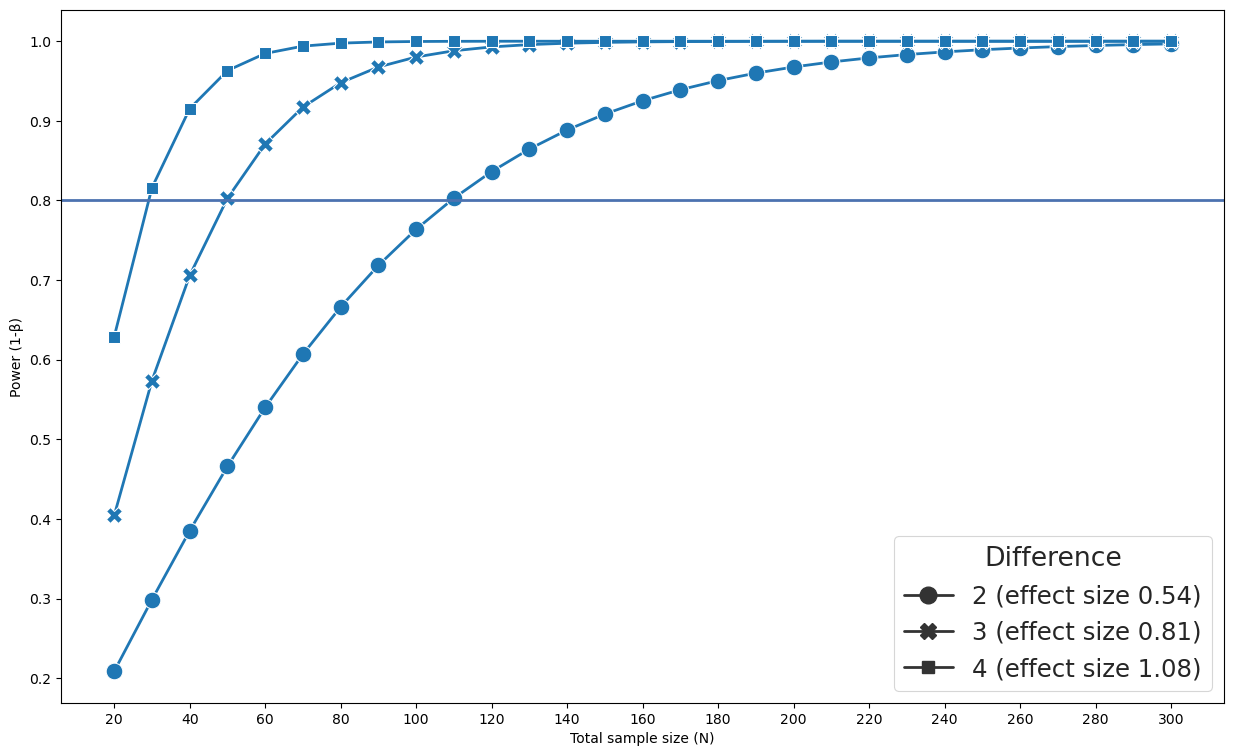

In [11]:
fig, ax1 = plt.subplots(figsize=(15, 9))

sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2, 
                rc={'lines.linewidth': 2, 'lines.markersize': 12})

f = sns.lineplot(x='Total sample size (N)', y='Power (1-β)',
                 markers=True, dashes=False, style='Difference',
                 ax=ax1, data=data_alpha)
ax1.xaxis.set_major_locator(plt.MultipleLocator(20))

plt.axhline(0.8, 0, data_alpha['Total sample size (N)'].max())

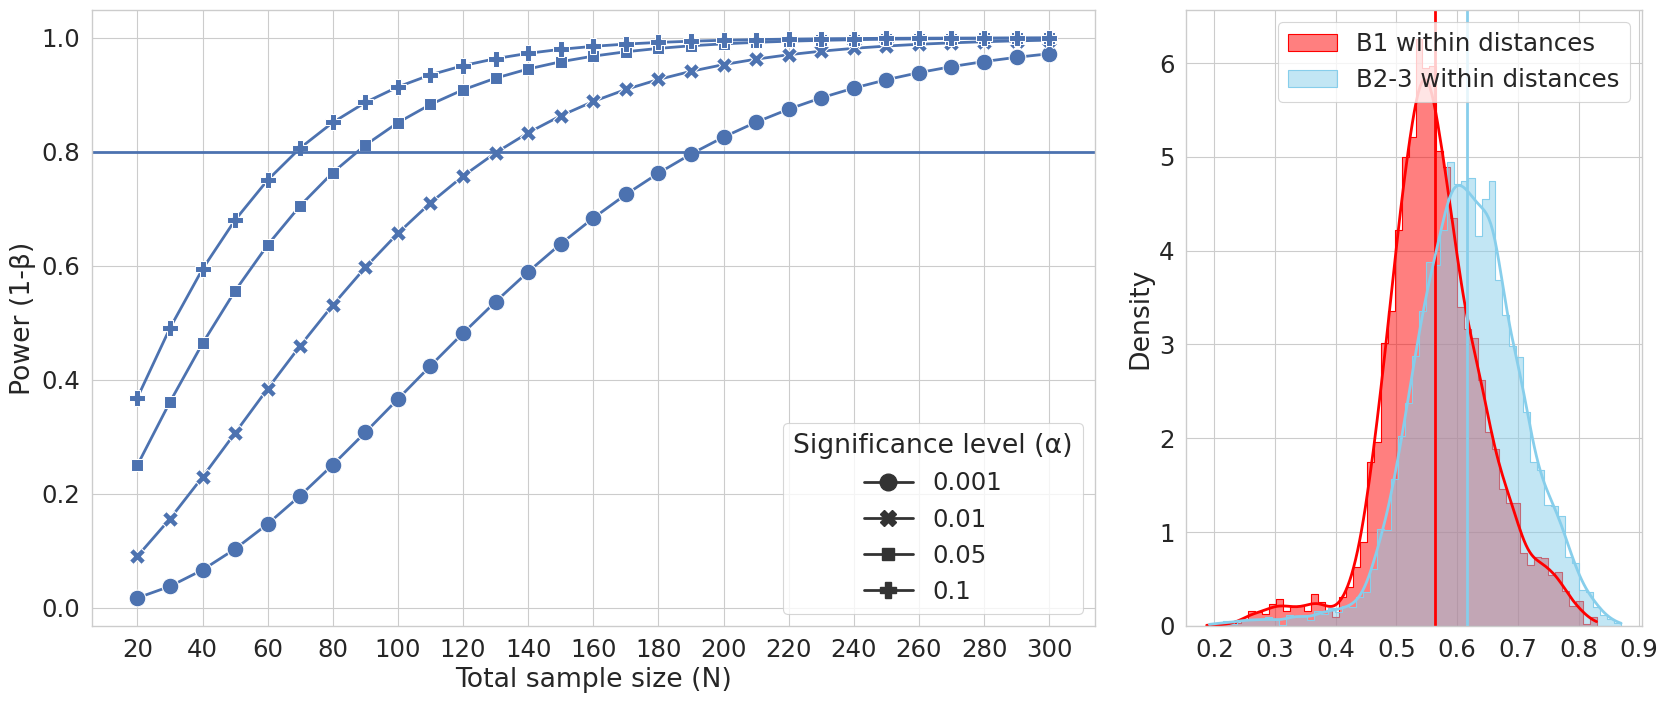

In [12]:
fig = plt.figure(figsize=(20, 8))
grid = plt.GridSpec(ncols=3, nrows=1, hspace=0.2, wspace=0.2)

ax1 = fig.add_subplot(grid[0, :2])
ax2 = fig.add_subplot(grid[0, 2:])

# LEFT: beta power curves (unchanged)
sns.lineplot(x='Total sample size (N)', y='Power (1-β)',
             style='Significance level (α)',
             markers=True, dashes=False,
             ax=ax1, data=data_beta)
ax1.axhline(0.8, 0, data_beta['Total sample size (N)'].max())
ax1.xaxis.set_major_locator(plt.MultipleLocator(20))

# RIGHT: distributions using histplot (+ KDE) instead of distplot
sns.histplot(b1_dtx,
             label="B1 within distances",
             color="red",
             kde=True,
             stat="density",
             element="step",
             ax=ax2)

ax2.axvline(mean(b1_dtx), 0, 6, color="red")

sns.histplot(bother_dtx,
             label="B2-3 within distances",
             color="skyblue",
             kde=True,
             stat="density",
             element="step",
             ax=ax2)

ax2.axvline(mean(bother_dtx), 0, 6, color="skyblue")

ax2.xaxis.set_major_locator(plt.MultipleLocator(.1))
ax2.legend()
